## SpaCy Install

In [1]:
pip install spacy

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install en-core-web-sm

Note: you may need to restart the kernel to use updated packages.


# Generate ESG Terms using Spacy and Select them for Context

In [3]:
import spacy
nlp = spacy.load("en_core_web_sm")
import re
import logging
from pathlib import Path
import spacy
from spacy.matcher import PhraseMatcher
import pandas as pd

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Expanded list of ESG-related terms (merging "corporate governance" into "governance")
ESG_TERMS = [
    "executive compensation",
    "stock-based compensation",
    "compensation committee",
    "governance",
    "board of directors",
    "environmental impact",
    "sustainability",
    "social responsibility",
    "diversity and inclusion",
    "climate change",
    "carbon emissions",
    "energy efficiency",
    "water management",
    "labor practices",
    "human rights",
    "community engagement",
]

def build_phrase_matcher(nlp, terms):
    matcher = PhraseMatcher(nlp.vocab)
    patterns = [nlp.make_doc(term) for term in terms]
    matcher.add("ESG_TERMS", patterns)
    return matcher

def process_text(text, matcher, nlp):
    """Process text using spaCy to extract ESG terms with their sentence context."""
    doc = nlp(text)
    matches = matcher(doc)
    results = []
    for match_id, start, end in matches:
        span = doc[start:end]
        term = span.text.lower()
        if term == "corporate governance":
            term = "governance"
        # Capture the full sentence as context
        context = span.sent.text
        results.append((term, context))
    return results

def process_file(file_path, nlp, matcher):
    """Process a single file and return ESG matches."""
    try:
        text = file_path.read_text(encoding='utf-8')
    except Exception as e:
        logging.error(f"Error reading file {file_path}: {e}")
        return []
    results = process_text(text, matcher, nlp)
    return results

def write_report(results, output_file):
    """Write extracted ESG matches to the output report file."""
    output_path = Path(output_file)
    try:
        with output_path.open('w', encoding='utf-8') as f:
            for filename, term, context in results:
                f.write(f"File: {filename}\nTerm: {term}\nContext: {context}\n\n")
        logging.info(f"Report successfully written to {output_file}")
    except Exception as e:
        logging.error(f"Error writing report to {output_file}: {e}")

def parse_report_to_dataframe(report_file):
    """Parse a report file into a pandas DataFrame and extract the year from filenames."""
    data = []
    current_year = None
    year_pattern = re.compile(r'(\d{4})')
    with open(report_file, "r", encoding="utf-8") as f:
        for line in f:
            if line.startswith("File:"):
                current_file = line.strip().split(": ", 1)[1]
                match = year_pattern.search(current_file)
                current_year = int(match.group(1)) if match else None
            elif line.startswith("Term:"):
                term = line.strip().split(": ", 1)[1]
            elif line.startswith("Context:"):
                context = line.strip().split(": ", 1)[1]
                if current_year is not None:
                    data.append({"Year": current_year, "Term": term, "Context": context})
    df = pd.DataFrame(data)
    return df

def group_contexts(df):
    """Group contexts by Year and Term, concatenating multiple sentences into one chunk."""
    chunked_data = df.groupby(["Year", "Term"])["Context"].apply(" ".join).reset_index()
    return chunked_data

def main():
    nlp = spacy.load("en_core_web_sm")
    matcher = build_phrase_matcher(nlp, ESG_TERMS)
    
    folder_path = Path("/Users/colebarrett/Desktop/UCSD/MQF/data_science/Final_Project/10k_text")
    output_folder = Path("/Users/colebarrett/Desktop/UCSD/MQF/data_science/Final_Project/individual_reports")
    output_folder.mkdir(exist_ok=True)
    
    # Process each file individually
    for file_path in folder_path.glob("*.txt"):
        logging.info(f"Processing {file_path.name}...")
        results = process_file(file_path, nlp, matcher)
        # Tag results with the filename so it's clear in the report
        tagged_results = [(file_path.name, term, context) for term, context in results]
        
        # Write a separate ESG report for each file
        output_report = output_folder / f"esg_report_{file_path.stem}.txt"
        write_report(tagged_results, output_report)
        
        # Optionally, parse and group data for further analysis
        df = parse_report_to_dataframe(output_report)
        chunked_data = group_contexts(df)
        logging.info(f"Grouped Analysis for {file_path.name}:")
        print(chunked_data.head())
        
if __name__ == "__main__":
    main()

2025-03-11 16:53:44,816 - INFO - Processing IONQ_2022_Cleaned.txt...
2025-03-11 16:53:58,346 - INFO - Report successfully written to /Users/colebarrett/Desktop/UCSD/MQF/data_science/Final_Project/individual_reports/esg_report_IONQ_2022_Cleaned.txt
2025-03-11 16:53:58,353 - INFO - Grouped Analysis for IONQ_2022_Cleaned.txt:
2025-03-11 16:53:58,356 - INFO - Processing IONQ_2021_Cleaned.txt...


   Year                      Term  \
0  2022        board of directors   
1  2022    executive compensation   
2  2022                governance   
3  2022  stock-based compensation   

                                             Context  
0  Risks associated with our status as a public c...  
1  These provisions include: (1) presenting only ...  
2  We compete based on various factors, including...  
3  Personnel-related expenses include salaries, b...  


2025-03-11 16:54:08,686 - INFO - Report successfully written to /Users/colebarrett/Desktop/UCSD/MQF/data_science/Final_Project/individual_reports/esg_report_IONQ_2021_Cleaned.txt
2025-03-11 16:54:08,691 - INFO - Grouped Analysis for IONQ_2021_Cleaned.txt:
2025-03-11 16:54:08,692 - INFO - Processing IONQ_2023_Cleaned.txt...


   Year                    Term  \
0  2021      board of directors   
1  2021  compensation committee   
2  2021  executive compensation   
3  2021              governance   

                                             Context  
0  Our board of directors will make the determina...  
1  Committees of the Board of Directors Our board...  
2  We are an  emerging growth company  within the...  
3  In accordance with the NYSE s corporate govern...  


2025-03-11 16:54:19,665 - INFO - Report successfully written to /Users/colebarrett/Desktop/UCSD/MQF/data_science/Final_Project/individual_reports/esg_report_IONQ_2023_Cleaned.txt
2025-03-11 16:54:19,670 - INFO - Grouped Analysis for IONQ_2023_Cleaned.txt:


   Year                      Term  \
0  2023        board of directors   
1  2023    executive compensation   
2  2023                governance   
3  2023  stock-based compensation   

                                             Context  
0  As part of the consolidated amended complaint,...  
1  These provisions include: (1) presenting only ...  
2  We compete based on various factors, including...  
3  Personnel-related expenses include salaries, b...  


# Parse the cleaned Data for Frequently Used Terms

2025-03-11 16:54:20,207 - INFO - Parsing report: esg_report_IONQ_2021_Cleaned.txt
2025-03-11 16:54:20,208 - INFO - Parsing report: esg_report_IONQ_2022_Cleaned.txt
2025-03-11 16:54:20,210 - INFO - Parsing report: esg_report_IONQ_2023_Cleaned.txt


Frequency of ESG Terms Detected:
                       Term  Count
0        board of directors    159
4  stock-based compensation     38
3                governance     25
2    executive compensation     13
1    compensation committee     12


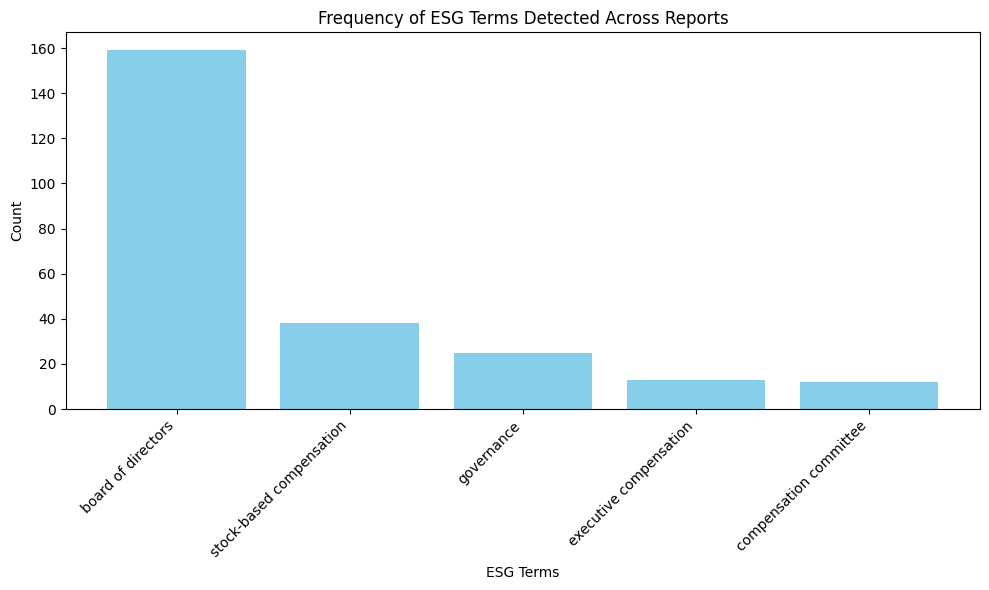

In [4]:
import re
import logging
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# We'll reuse your parse_report_to_dataframe function
def parse_report_to_dataframe(report_file):
    """Parse a report file into a pandas DataFrame and extract the year from filenames."""
    data = []
    current_year = None
    year_pattern = re.compile(r'(\d{4})')
    with open(report_file, "r", encoding="utf-8") as f:
        for line in f:
            if line.startswith("File:"):
                current_file = line.strip().split(": ", 1)[1]
                match = year_pattern.search(current_file)
                current_year = int(match.group(1)) if match else None
            elif line.startswith("Term:"):
                term = line.strip().split(": ", 1)[1]
            elif line.startswith("Context:"):
                context = line.strip().split(": ", 1)[1]
                if current_year is not None:
                    data.append({"Year": current_year, "Term": term, "Context": context})
    df = pd.DataFrame(data)
    return df

def aggregate_reports(folder_path):
    """Aggregate all separate ESG report files into one DataFrame."""
    folder = Path(folder_path)
    df_list = []
    for report_file in folder.glob("*.txt"):
        logging.info(f"Parsing report: {report_file.name}")
        df = parse_report_to_dataframe(report_file)
        df_list.append(df)
    if df_list:
        aggregated_df = pd.concat(df_list, ignore_index=True)
    else:
        aggregated_df = pd.DataFrame(columns=["Year", "Term", "Context"])
    return aggregated_df

def frequency_analysis(df):
    """Compute frequency counts for each ESG term."""
    frequency = df.groupby("Term").size().reset_index(name="Count")
    return frequency

def main_analysis():
    # Path to your folder with individual ESG reports
    reports_folder = "/Users/colebarrett/Desktop/UCSD/MQF/data_science/Final_Project/individual_reports"
    aggregated_df = aggregate_reports(reports_folder)
    
    # Frequency counts per ESG term
    frequency_df = frequency_analysis(aggregated_df)
    frequency_df = frequency_df.sort_values("Count", ascending=False)
    print("Frequency of ESG Terms Detected:")
    print(frequency_df)
    
    # Plotting the frequency as a bar chart
    plt.figure(figsize=(10,6))
    plt.bar(frequency_df["Term"], frequency_df["Count"], color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("ESG Terms")
    plt.ylabel("Count")
    plt.title("Frequency of ESG Terms Detected Across Reports")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    main_analysis()

# Conduct Trend Analysis


2025-03-11 16:56:14,161 - INFO - Parsing report: esg_report_IONQ_2021_Cleaned.txt
2025-03-11 16:56:14,166 - INFO - Parsing report: esg_report_IONQ_2022_Cleaned.txt
2025-03-11 16:56:14,168 - INFO - Parsing report: esg_report_IONQ_2023_Cleaned.txt


<Figure size 1200x800 with 0 Axes>

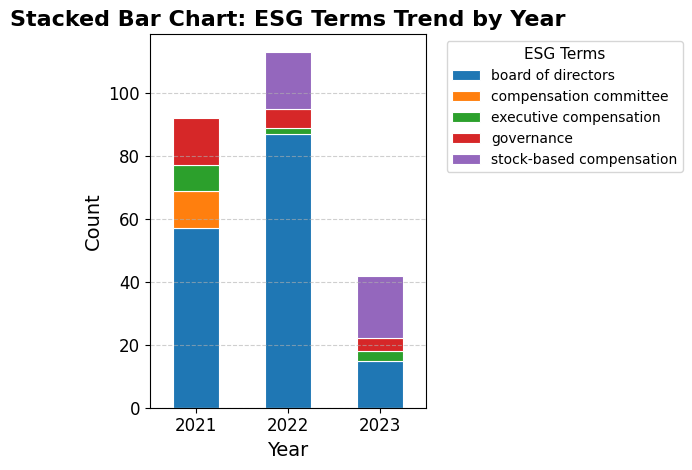

In [7]:
import seaborn as sns

import matplotlib.pyplot as plt

def trend_analysis(df):
    # Group the data by Year and Term and count occurrences
    df_counts = df.groupby(["Year", "Term"]).size().reset_index(name='Count')
    
    # Pivot the data so that each ESG term becomes its own column
    pivot_df = df_counts.pivot(index="Year", columns="Term", values="Count").fillna(0)
    
    custom_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
    plt.figure(figsize=(12, 8))
    pivot_df.plot(
        kind="bar",
        stacked=True,
        edgecolor="white",
        linewidth=0.8,
        color=custom_colors
    )
    plt.title("Stacked Bar Chart: ESG Terms Trend by Year", fontsize=16, fontweight="bold")
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title="ESG Terms", title_fontsize=11, fontsize=10, loc="upper left", bbox_to_anchor=(1.05, 1))
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

def main_trend():
    # Path to your folder with individual ESG reports
    reports_folder = "/Users/colebarrett/Desktop/UCSD/MQF/data_science/Final_Project/individual_reports"
    aggregated_df = aggregate_reports(reports_folder)
    
    trend_analysis(aggregated_df)

if __name__ == "__main__":
    main_trend()

2025-03-11 16:59:10,035 - INFO - Parsing report: esg_report_IONQ_2021_Cleaned.txt
2025-03-11 16:59:10,041 - INFO - Parsing report: esg_report_IONQ_2022_Cleaned.txt
2025-03-11 16:59:10,042 - INFO - Parsing report: esg_report_IONQ_2023_Cleaned.txt


<Figure size 1200x600 with 0 Axes>

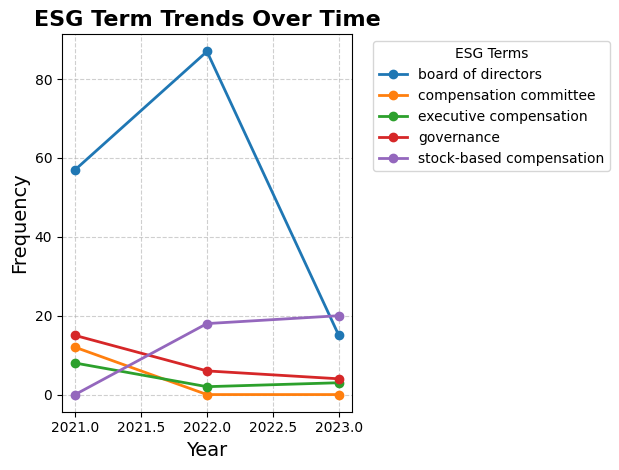

In [17]:
def line_trend_analysis(df):
    df_counts = df.groupby(["Year", "Term"]).size().reset_index(name="Count")
    pivot_df = df_counts.pivot(index="Year", columns="Term", values="Count").fillna(0)

    plt.figure(figsize=(12, 6))
    pivot_df.plot(marker="o", linestyle="-", linewidth=2)
    plt.title("ESG Term Trends Over Time", fontsize=16, fontweight="bold")
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.legend(title="ESG Terms", bbox_to_anchor=(1.05, 1), fontsize=10)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# Aggregate reports to create the aggregated_df DataFrame
reports_folder = "/Users/colebarrett/Desktop/UCSD/MQF/data_science/Final_Project/individual_reports"
aggregated_df = aggregate_reports(reports_folder)

# Apply line_trend_analysis to the aggregated data
line_trend_analysis(aggregated_df)



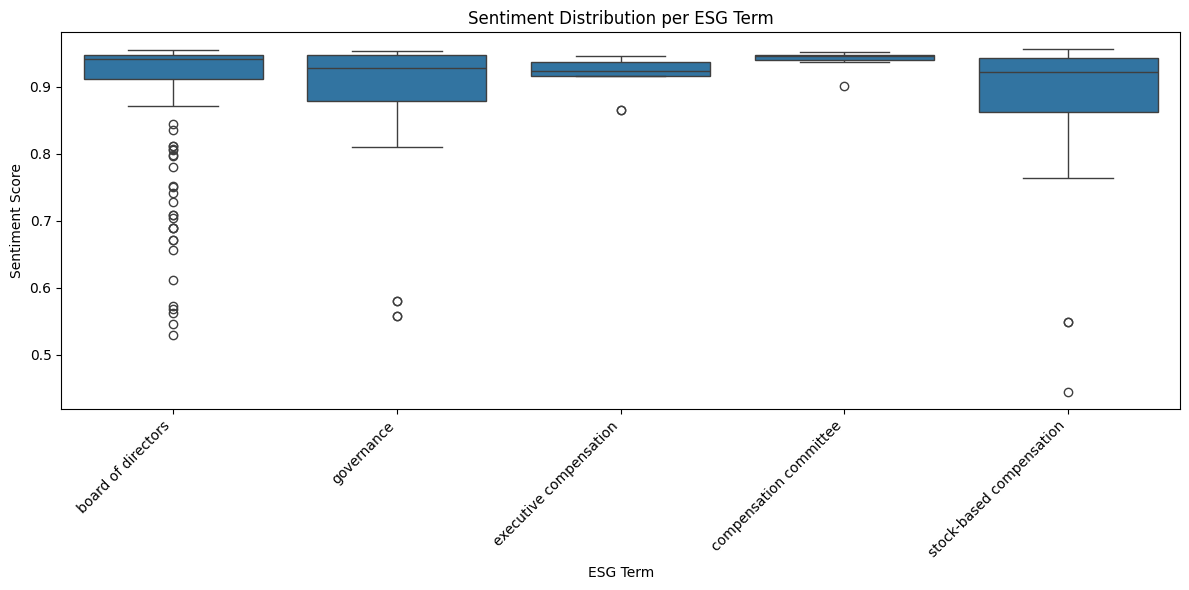

In [18]:

def plot_sentiment_boxplot(df):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='Term', y='FinBERT_Confidence')
    plt.xticks(rotation=45, ha='right')
    plt.title("Sentiment Distribution per ESG Term")
    plt.xlabel("ESG Term")
    plt.ylabel("Sentiment Score")
    plt.tight_layout()
    plt.show()


plot_sentiment_boxplot(df_sentiment)


# Install and Utilize FinBERT

In [19]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
# Load the FinBERT model and tokenizer
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

def get_finbert_sentiment(text):
    # Tokenize and encode text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    
    # Convert logits to probabilities
    probs = torch.nn.functional.softmax(logits, dim=1)
    
    # The index with the highest probability
    label_idx = torch.argmax(probs, dim=1).item()
    
    # FinBERT’s order: [negative, neutral, positive]
    labels = ["negative", "neutral", "positive"]
    sentiment = labels[label_idx]
    confidence = probs[0][label_idx].item()
    
    return sentiment, confidence

def apply_finbert(df):
    sentiments = []
    confidences = []
    for context in df["Context"]:
        s, c = get_finbert_sentiment(context)
        sentiments.append(s)
        confidences.append(c)
    df["FinBERT_Sentiment"] = sentiments
    df["FinBERT_Confidence"] = confidences
    return df

df_sentiment = apply_finbert(df_sentiment)
print(df_sentiment.head())

sentiment_counts = df_sentiment["FinBERT_Sentiment"].value_counts()
print(sentiment_counts)

   Year                Term  \
0  2021  board of directors   
1  2021  board of directors   
2  2021  board of directors   
3  2021  board of directors   
4  2021  board of directors   

                                             Context FinBERT_Sentiment  \
0  Our board of directors will make the determina...          positive   
1  If our board of directors is not able to indep...          positive   
2  While we consider it unlikely that our board o...          positive   
3  If we are unable to complete our initial busin...          positive   
4  Our officers are appointed by the board of dir...          positive   

   FinBERT_Confidence  
0            0.913432  
1            0.930990  
2            0.781002  
3            0.944480  
4            0.935301  
FinBERT_Sentiment
positive    219
neutral      19
negative      9
Name: count, dtype: int64


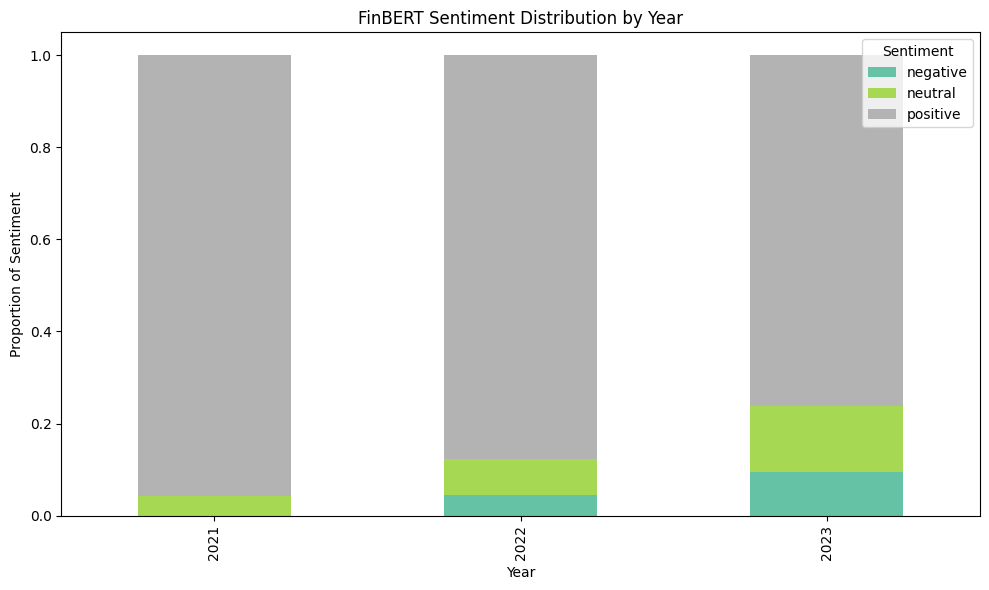

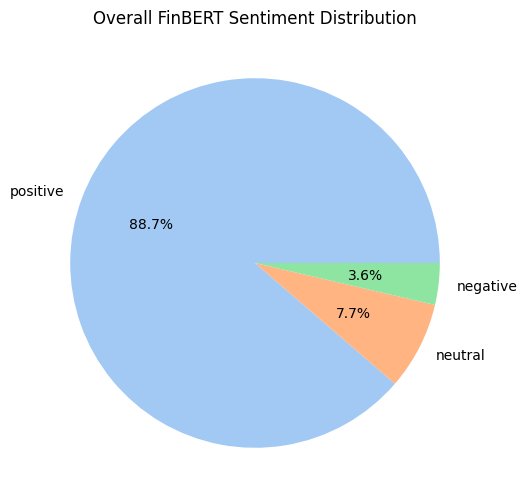

/var/folders/x1/z9s4pn957b18rcjs_5cwh1d40000gn/T/ipykernel_81697/3122543322.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="FinBERT_Sentiment", y="FinBERT_Confidence", data=avg_confidence, palette="viridis")


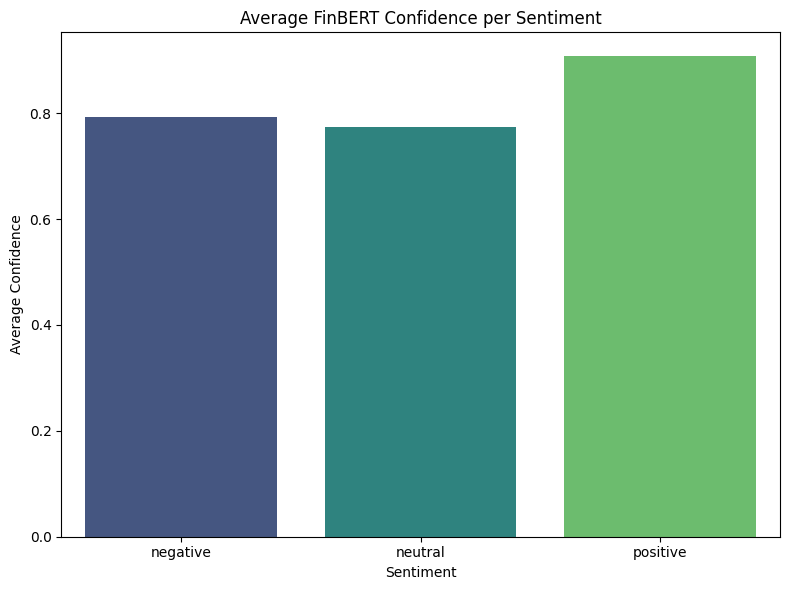

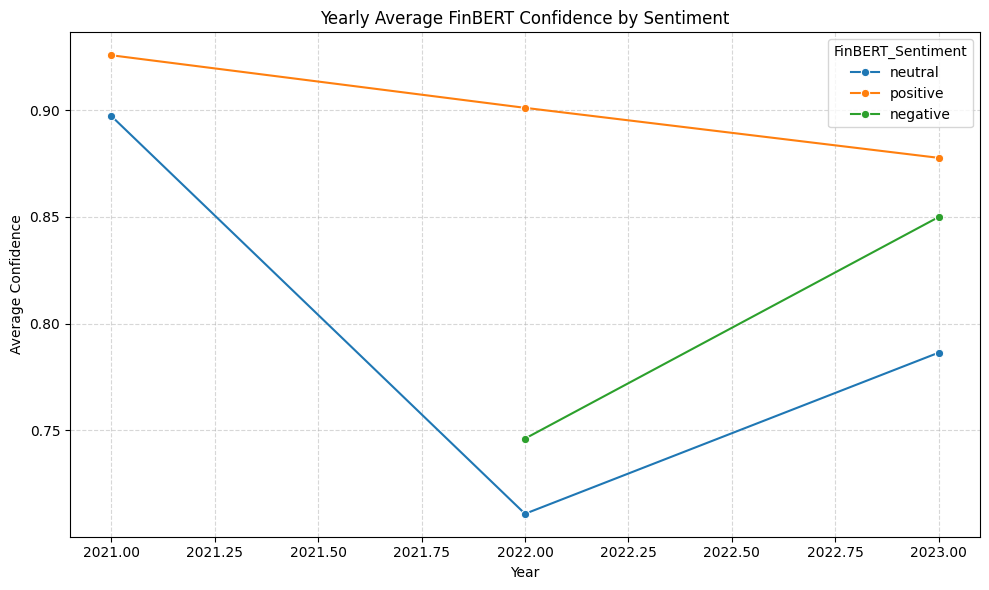

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_finbert_trends(df):
    # Group by Year and FinBERT_Sentiment, count occurrences
    yearly_sentiment = df.groupby(["Year", "FinBERT_Sentiment"]).size().reset_index(name="Count")
    
    # Pivot so each sentiment label is a column
    pivot_sentiment = yearly_sentiment.pivot(index="Year", columns="FinBERT_Sentiment", values="Count").fillna(0)
    
    # Convert counts to percentages
    pivot_sentiment_pct = pivot_sentiment.apply(lambda row: row / row.sum(), axis=1)
    
    # Stacked bar chart of percentages
    pivot_sentiment_pct.plot(kind="bar", stacked=True, figsize=(10,6), cmap="Set2")
    plt.title("FinBERT Sentiment Distribution by Year")
    plt.xlabel("Year")
    plt.ylabel("Proportion of Sentiment")
    plt.legend(title="Sentiment")
    plt.tight_layout()
    plt.show()

plot_finbert_trends(df_sentiment)

# 1. Pie chart for overall FinBERT sentiment distribution
fig, ax = plt.subplots(figsize=(6,6))
sentiment_counts = df_sentiment["FinBERT_Sentiment"].value_counts()
ax.pie(sentiment_counts, labels=sentiment_counts.index, autopct="%1.1f%%", colors=sns.color_palette("pastel"))
ax.set_title("Overall FinBERT Sentiment Distribution")
plt.show()

# 2. Bar chart for average FinBERT confidence per sentiment label
plt.figure(figsize=(8,6))
avg_confidence = df_sentiment.groupby("FinBERT_Sentiment")["FinBERT_Confidence"].mean().reset_index()
sns.barplot(x="FinBERT_Sentiment", y="FinBERT_Confidence", data=avg_confidence, palette="viridis")
plt.title("Average FinBERT Confidence per Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Average Confidence")
plt.tight_layout()
plt.show()

# 3. Line chart for yearly average FinBERT confidence by sentiment
plt.figure(figsize=(10,6))
yearly_confidence = df_sentiment.groupby(["Year", "FinBERT_Sentiment"])["FinBERT_Confidence"].mean().reset_index()
sns.lineplot(x="Year", y="FinBERT_Confidence", hue="FinBERT_Sentiment", data=yearly_confidence, marker="o")
plt.title("Yearly Average FinBERT Confidence by Sentiment")
plt.xlabel("Year")
plt.ylabel("Average Confidence")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()



In [ ]:
def print_extreme_examples(df, label="negative", top_n=5):
    # Filter only the chosen label
    subset = df[df["FinBERT_Sentiment"] == label]
    # Sort by confidence descending
    subset = subset.sort_values(by="FinBERT_Confidence", ascending=False)
    print(f"Top {top_n} most confidently {label} snippets:")
    for i, row in subset.head(top_n).iterrows():
        print(f"Confidence: {row['FinBERT_Confidence']:.3f} | Context: {row['Context'][:200]}...")
    print("\n")

print_extreme_examples(df_sentiment, label="negative", top_n=3)
print_extreme_examples(df_sentiment, label="positive", top_n=3)

Top 3 most confidently negative snippets:
Confidence: 0.947 | Context: The increase was primarily driven by an increase of $14.9 million in payroll-related expenses, including an increase in stock-based compensation of $11.0 million, due to increased headcount, and an in...
Confidence: 0.944 | Context: The increase was primarily driven by an increase of $6.3 million in payroll-related expenses, including an increase in stock-based compensation of $4.3 million, due to increased headcount to support t...
Confidence: 0.938 | Context: The increase was primarily driven by an $18.1 million increase in payroll-related expenses, including stock-based compensation of $10.6 million, as a result of increased headcount, a $2.6 million incr...


Top 3 most confidently positive snippets:
Confidence: 0.954 | Context: Preferred Stock The Company is authorized to issue 1,000,000 shares of preferred stock, par value $0.0001 per share, with such designations, voting and other rights and preferences as ma